<a href="https://colab.research.google.com/github/vparro/controleAvancado/blob/master/Encontro_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bibliotecas**

In [116]:
# Importação de módulos e instalação de bibliotecas adicionais

# Importação do pacote matématico Math
import math

# Importação do pacote Pandas
import pandas as pd

# Importação dos pacotes NumPy e SciPy
import numpy as np
import sympy as sp
from scipy.interpolate import interp1d
from scipy import signal

from scipy.integrate import odeint
from scipy.integrate import solve_ivp
from scipy.misc import derivative

# Importação do pacote PyPlot do MatPlotLib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

# Instalação e importação do pacote mpld3
!pip install mpld3
import mpld3

from mpl_toolkits.mplot3d import Axes3D

# importação do módulo timeit
import timeit

In [ ]:
# Diretiva do Notebook para exibição de gráficos inline
%matplotlib inline

# Configuração do tamanho dos gráficos
plt.rcParams["figure.figsize"] = (20,10)

#**Sistemas**

## Sistemas lineares - simulação

Para um determinado sistema diâmico modelado pela função de transferência:

$$\begin{equation}
G(s)=\frac{1}{s+1} =\frac{Y(s)}{X(s)}
\end{equation}$$

onde $Y(s)$ é a saída do sistema e $X(s)$ é a entrada do sistema. Podemos escrever a respectiva equação diferencial a partir da anti transformada de Laplace - $\mathcal{L}^{-1}$.


$$\begin{equation}
SY(s) + Y(s) = X(s)
\end{equation}$$

$$\begin{equation}
\dot{y}(t) + y(t) = x(t)
\end{equation}$$

onde $\dot{y}(t) = \frac{dy(t)}{dt}$.

Desejamos determinar a saída do sistema para o caso de um antreda do tipo degrau unitário, aplicado no instante $t = 10s$.

$
    u(t)= 
\begin{cases}
    1, &  t\geq 0\\
    0, & \text{caso contrário}
\end{cases}$


In [123]:
###################################################################################################
# função que retorna dy/dt

def model(y,t):
    # u steps from 0 to 1 at t=10

    if t<10.0:
        u = 0
    else:
        u = 1
    dydt = (-y + u)
    return dydt

# Condição inicial
y0 = 0

# vetor tempo
t = np.linspace(0,40,1000)

# Resolvendo a EDO
y = odeint(model,y0,t)

###################################################################################################
# Visualização

fig = plt.figure()
plt.plot(t,y,'r-',label='Saída(y(t))')
plt.plot([0,10,10,40],[0,0,1,1],'b-',label='Entrada(u(t))')
plt.ylabel('Amplitude')
plt.xlabel('tempo')
plt.legend(loc='best')

# Criação e exibição de tooltips no gráfico
mpld3.plugins.connect(fig, mpld3.plugins.MousePosition(fontsize=14))
mpld3.display()

## Sistema com parâmetro variável

Para um caso mais complexo, onde temos um cojunto de equações diferenciais e, um dos parâmetros está condicionado a evolução das variáveis envolvidas:

$ \begin{align*} 
\dot{T}(t) &=  1 - T(t) - k_1T(t) \\ 
\dot{S}(t) &=  0.1(1-S(t)) - k_1S(t) \\
p(t) &= -0.2T(t)+S(t) 
\end{align*} $

sabendo que a lei para $k_1$ é dada por:

$
    k_1(t)= 
\begin{cases}
    0, &  p(t)\leq 0.01\\
    5, & \text{caso contrário}
\end{cases}$



In [124]:
###################################################################################################
# função que retorna dy/dt

def model(t, TS):
    T, S = TS

    p = -0.2*T + S
    k1 = 0 if p <= 0.01 else 5

    dTdt = 1 - T - k1*T
    dSdt = 0.1*(1 - S) - k1*S

    return dTdt, dSdt

###################################################################################################

TS_start = (0.7, 0.4)
t_span = [0, 3]
sol = solve_ivp(model, t_span, TS_start, method='RK45',
                rtol=1e-5)
print(sol.message)
print('nbr eval', sol.nfev)

###################################################################################################
# Visualização

fig = plt.figure()
plt.plot(sol.t, sol.y[0, :], label='T')
plt.plot(sol.t, sol.y[1, :], label='S'); plt.legend();
plt.xlabel('tempo');
plt.ylabel('Amplitude')
plt.grid(color='y', linestyle='-.', linewidth=1)

# Criação e exibição de tooltips no gráfico
mpld3.plugins.connect(fig, mpld3.plugins.MousePosition(fontsize=14))
mpld3.display()


The solver successfully reached the end of the integration interval.
nbr eval 94346


# **Modelagem**

Vamos analisar o sistema dinâmico correspondente a um tanque cuja alimentação ocorre na parte superior, por um sistema de bombeamento e esvaziamento por um orifício na base do tanque. Conforme obtivemos nas primeiras aulas, para uma geometria específica, regido pela equação diferencial apresentada. A equação diferencial  corresponde a um tanque cilíndrico, com formato próximo ao formato de um refrigerante de 2 litros alimentado por uma bomba, semelhante ao de um sistema de carro. Neste equação o variável $h(t)$ representa o nível de fluído no tanque e a variável $e_a(t)$ indica a tensão aplicada em um bomba de comportamento linear e dinâmica desprezível. Analisando a equação constatamos a presença de um termo não linear na Equação que inviabiliza sua transformada de \textit{Laplace} diretamente - $ \sqrt{h(t)} $. Nesta equação temos: $A=78 \;cm^2$, $K_1=1.32\frac{cm^3}{sV}$ e $A_o \sqrt{2g} = 2.7 \frac{cm^{2.5}}{s}$ A Equação diferencial pode ser descrita em linguagem modelada de acordo com o diagrama ilustrado na Figura. 

\begin{equation}
    78\frac{dh(t)}{dt}=1.32 e_a(t)-2.7\sqrt{h(t)}
\end{equation}

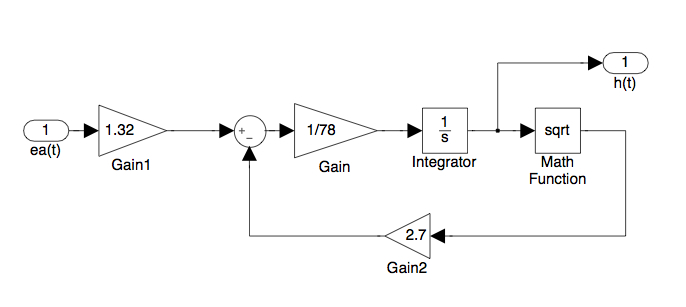

Supondo que desejamos controlar o nível $h(t)$ do tanque em torno de um ponto de interesse $h_0$, o estado estacionário (ponto de equilíbrio) corresponde a situação onde a vazão de entrada é idêntica a vazão de saída. Para obter esta condição, basta considerar o termo da derivada na Equação como zero e obtemos uma relação governada pela Equação. Com o uso apropriado da Equação  podemos obter qual a tensão pode estabilizar o nível em determinado valor e \textit{vice-versa}. Vale observar que existem infinitos pontos de equilíbrio limitados a altura física do tanque ($h_{max}$).

\begin{equation}
    1.32 e_{a0}=2.7\sqrt{h_0}
\end{equation}

Para podermos tratar o sistema em torno do ponto de interesse, devemos linearizar o termo não linear. Podemos utilizar a série de Taylor e truncar o valor no termo de primeira ordem resultando na Equação \ref{eq:03}.

\begin{align}
\begin{split}
 \sqrt{h(t)} \doteq \sqrt{h_0} + (h(t)-h_0) \frac{d\sqrt{h(t)}}{dt}\vert_{h_0},
\\
 \sqrt{h(t)} \doteq \sqrt{h_0} + (h(t)-h_0) \frac{1}{2\sqrt{h_0}}.
\end{split}
\end{align}

Substituindo os resultados temos a equação linear modelada . Observe que quando substituímos o termo linear por sua aproximação obtemos exatamente uma parcela que corresponde a Equação final. Desta forma, se trocarmos o termo $2.7\sqrt{h_0}$ por $1.32 e_{a0}$ podemos estabelecer uma equação de variação, onde: $\Delta h(t) =h(t)-h_0$ e  $\Delta e_a(t) = e_a(t)-e_{a0}$. Observe também que: $\frac{d(h(t)-h_0)}{dt} = \frac{dh(t)}{dt} = \frac{\Delta h(t)}{dt} $ pois $h_0$ é uma constante na perspectiva desta análise.

\begin{align}
\begin{split}
78\frac{dh(t)}{dt}=1.32 e_a(t)-2.7\sqrt{h_0}-2.7((h(t)-h_0) \frac{1}{2\sqrt{h_0}}),
\\
78\frac{dh(t)}{dt}=1.32 e_a(t)-1.32 e_{a0}-2.7((h(t)-h_0) \frac{1}{2\sqrt{h_0}}),
\\
78\frac{d\Delta h(t)}{dt}=1.32 \Delta e_a(t)- \frac{2.7}{2\sqrt{h_0}} \Delta h(t).
\end{split}
\end{align}

Partindo do resultado obtido na manipulação apresentada pode-se facilmente obter a função de transferência do sistema em torno do ponto de equilíbrio escolhido $h_0$ e obtemos a Função de transferência descrita. O subscrito $\Delta$ que aparece nestas equações indica que trata-se de um modelo de desvios e não de um modelo para os valores absolutos. Um ponto importante é compararmos o comportamento entre o modelo linear e o modelo não linear em torno do ponto de operação $h_0$ (equilíbrio).

\begin{align}
\begin{split}
78 s H_{\Delta}(s)=1.32 E_{a\Delta}(s) - \frac{2.7}{2\sqrt{h_0}}H_{\Delta}(s),
\\
(78 s+ \frac{2.7}{2\sqrt{h_0}})H_{\Delta}(s)=1.32 E_{a\Delta}(s),
\\
\frac{H_{\Delta}(s)}{E_{a\Delta}(s)} = \frac{1.32}{(78 s+ \frac{2.7}{2\sqrt{h_0}})}.
\end{split}
\end{align}

Para simularmos ambos os sistema e compararmos o comportamento em torno de $h_0=6.5cm$ por exemplo, construímos o diagrama ilustrado na Figura. Observe que a entrada de ambos os sistemas não é igual. Ao aplicarmos no modelo não linear uma tensão $e_{a1}$ corresponde a um desvio de $e_{a1} - \frac{2.7 \sqrt{6.5}}{1.32}$ aplicado no modelo linear, relação obtida pela Equação. Outro aspecto é que a saída do modelo não linear oferece diretamente $h(t)$ e no caso do modelo linear temos o desvio, logo para obtermos o valor absoluto estimado precisamos adicionar $h_0=6.5$. Por último e não mesmo importante é a inicialização do integrador (Figura com o valor estável em torno do ponto em que estamos estudando $h_0=6.5$.

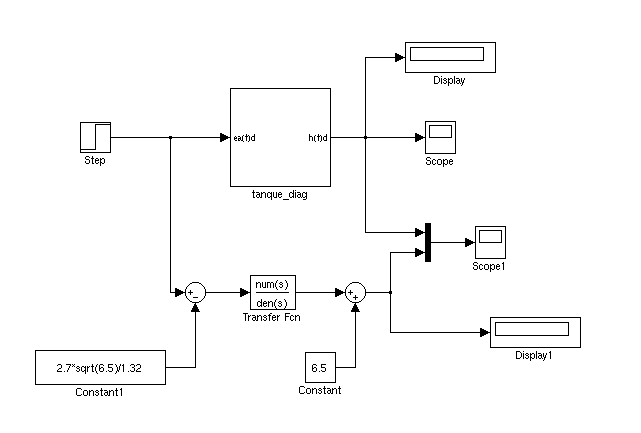

Após a comparação entre os modelos, podemos inferir limitações do mesmo e inseri-las para melhorar sua capacidade de previsão. Por exemplo, se aplicarmos $e_a(t)=1000V$ (\danger) o sistema aceitará e simulara a respectiva saída $h(t)$ que dependendo do valor pode chegar a quilômetros (\danger) o que é bastante improvável. Outro aspecto, natural é que as tensões são somente positivas na bomba, apesar do Matlab simular as tensões negativas, representando sucção de fluido, não é possível de obter fisicamente neste contexto sem mudar o atuador (Bomba). Adicionalmente o Matlab pode chegar a valores negativos de $h(t)$ o que também não faz sentido. A partir destas quatro observações concluímos que precisamos saturar tanto os valores de entrada em uma faixa $[e_{amin},e_{amax}]$ e a saída na faixa $[h_{min},h_{max}]$.

## Simulação malha aberta

In [125]:
###################################################################################################
# Constantes

A  = 78;
K1 = 1.32;
K2 = 2.7;

In [126]:
###################################################################################################
# Solução Analítica

sp.init_printing()

# Variáveis simbólicas

x,u = sp.symbols(['x','u'])

# Equação simbólica

dxdt = (K1*u - K2*sp.sqrt(x))/A

print(sp.diff(dxdt,x))
print(sp.diff(dxdt,u))


-0.0173076923076923/sqrt(x)
0.0169230769230769


In [127]:
###################################################################################################
# Solução numérica

# Condição de estado estacionário

u = K2/K1
x = 1

# Definindo as funções

def pd_x(x):
    dxdt =(K1*u - K2*sp.sqrt(x))/A
    return dxdt
def pd_u(u):
    dxdt =(K1*u - K2*sp.sqrt(x))/A
    return dxdt

###################################################################################################
# Visualização

print('Cálculo numérico')
print(derivative(pd_x,x,dx=1e-4))
print(derivative(pd_u,u,dx=1e-4))

print('Solução analítica')
print(-K2/(2*A*np.sqrt(x))) # exact d(f(x,u))/dx
print(K1/A) # exact d(f(x,u))/du



Cálculo numérico
-0.0173076923293269
0.0169230769231081
Solução analítica
-0.01730769230769231
0.016923076923076923


## Linearização

Para linearização utilizamos a Série de Taylor truncada no termo de primeira ordem

$\begin{equation}
f(x,u) = f(x_{ss},u_{ss}) + \frac{df(x,u)}{dx} \Delta \; x + \frac{df(x,u)}{du} \Delta \; u
\end{equation}$

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 0, 'u')

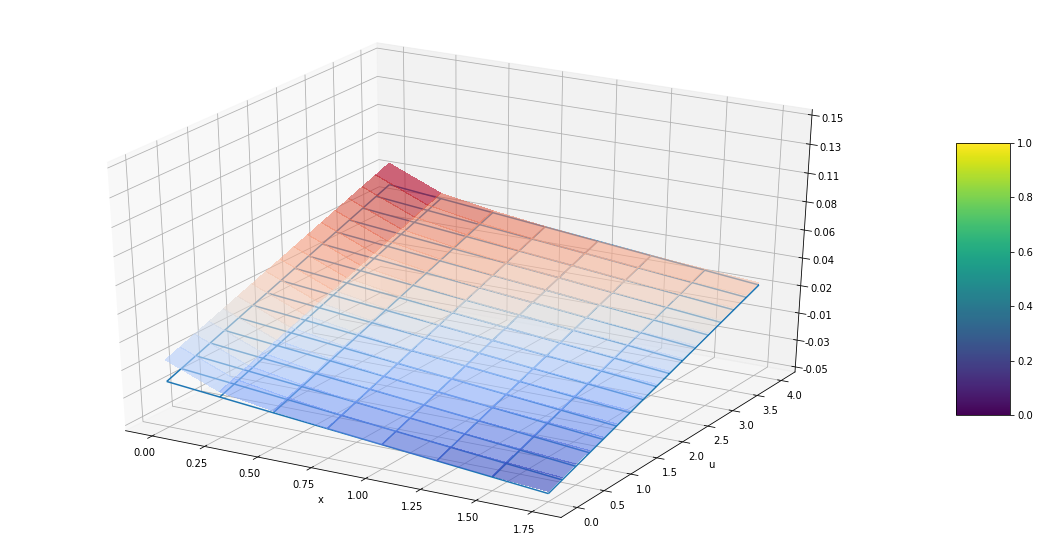

In [128]:
###################################################################################################

fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(0, 2*x, 0.25)
U = np.arange(0, 2*u, 0.25)
X, U = np.meshgrid(X, U)
DXDT = (K1*U - K2*np.sqrt(X))/A
LIN  = (K1*u - K2*np.sqrt(x))/A + (K1/A)* (U-u) - K2/(2*A*np.sqrt(x)) * (X-x)

# Plot the surface.
surf = ax.plot_surface(X, U, DXDT, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False, alpha=0.6)
surf = ax.plot_wireframe(X, U, LIN)


# Customize the z axis.
ax.set_zlim(-0.05, 0.15)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

# Add labels
plt.xlabel('x')
plt.ylabel('u')


## Comparação

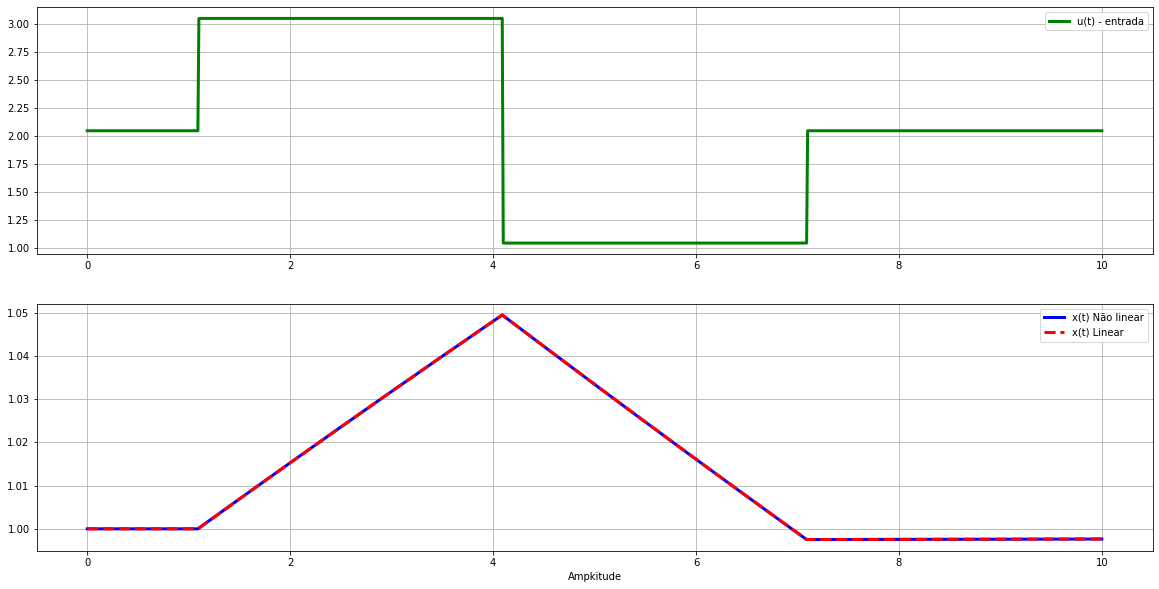

In [129]:
###################################################################################################
# Um modelo para ambos sistemas: linear e não linear

def model(z,t,u):
    x1 = z[0]
    x2 = z[1]
    dx1dt = (K1*u - K2*np.sqrt(x1))/A
    dx2dt = (K1*K2/K1 - K2*np.sqrt(1))/A + (K1/A)* (u-K2/K1) - K2/(2*A*np.sqrt(x2)) * (x2-1)
    dzdt = [dx1dt,dx2dt]
    return dzdt

# Condição de estado estacionário
x_ss = 1
u_ss = K2/K1

# condição inicial para o modelo
z0 = [x_ss,x_ss]

# tempo final
tf = 10

# número de pontos
n = tf * 100 + 1

# vetor tempo
t = np.linspace(0,tf,n)

###################################################################################################
# entrada

# degrau
u = np.ones(n) * u_ss

# amplitude
m = 1

# t = 1.0 segundo
u[110:] = u[110:] + m

# t = 4.0 segundo
u[410:] = u[410:] - 2.0 * m

# t = 7.0 segundo
u[710:] = u[710:] + m

# Guarda solução
x1 = np.empty_like(t)
x2 = np.empty_like(t)

# Codndições iniciais
x1[0] = z0[0]
x2[0] = z0[1]

###################################################################################################
# Solução numérica

for i in range(1,n):
    # range de análise
    tspan = [t[i-1],t[i]]

    # resolvendo para cada trecho
    z = odeint(model,z0,tspan,args=(u[i],))

    # gurda solução
    x1[i] = z[1][0]
    x2[i] = z[1][1]

    # Atualiza condição inicial
    z0 = z[1]

###################################################################################################
# Visualização

plt.figure(1)
plt.subplot(2,1,1)
plt.plot(t,u,'g-',linewidth=3,label='u(t) - entrada')
plt.grid()
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,x1,'b-',linewidth=3,label='x(t) Não linear')
plt.plot(t,x2,'r--',linewidth=3,label='x(t) Linear')
plt.xlabel('tempo')
plt.xlabel('Ampkitude')
plt.grid()
plt.legend(loc='best')
plt.show()

# **Controle malha fechada**

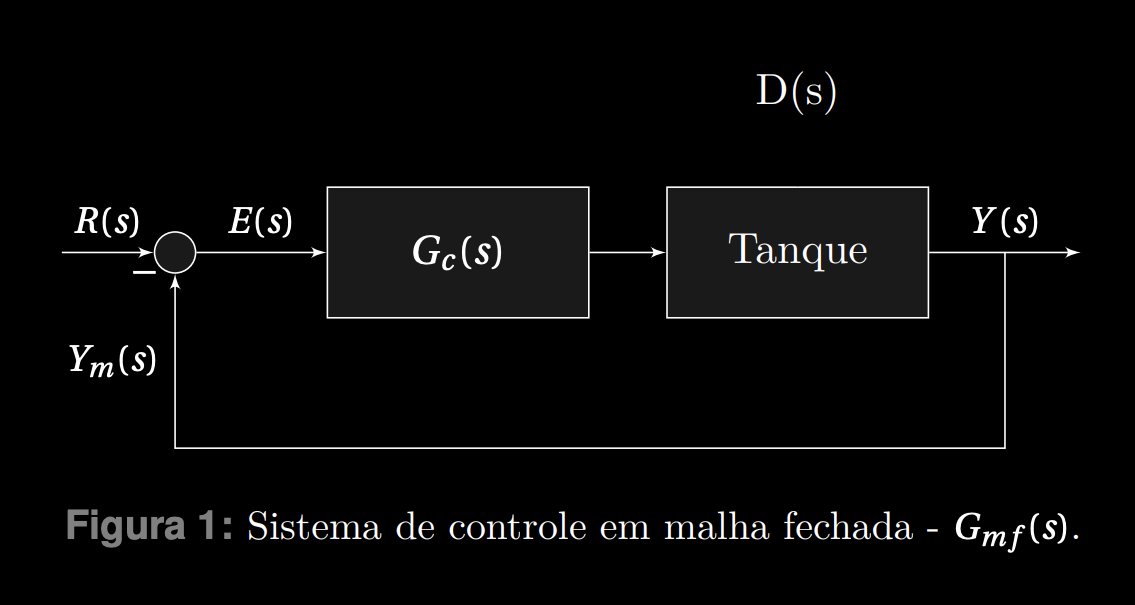

Para um sistema de controle em malha fechada temos

$\begin{equation}
G_{MF}(s) = \frac{Gc(s)Gp(s)}{1+Gc(s)Gp(s)}
\end{equation}$

## Controle em tempo contínuo

## Controle em tempo discreto

## Projeto do controlador

# **Validação**

# **Referências**

https://apmonitor.com/pdc/index.php/Main/ModelLinearization